In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2 # update libraries automoatically
%matplotlib inline 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import * 

In [0]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'fastai/HW1'

In [5]:
!ls "/content/drive/My Drive/fastai/HW1"

fastai-hw1.ipynb  jaguar_csv.csv  leopard_csv.csv


### Loading Jaguar and Leopard Images

In [0]:
'''
Go to google and make an image search such as "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

Then scroll down as far as you want and press cmd+opt+J to download the URLs

Then turn off adblock and paste this javascript into the window

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
'''


In [0]:
classes = ['jaguar', 'leopard']

In [7]:
path = Path(base_dir);path

PosixPath('/content/drive/My Drive/fastai/HW1')

### Jaguar Uploads

In [0]:
dest = path/'jaguar' # you need to specify where the actual image files are going to go to

In [0]:
download_images(path/'jaguar_csv.csv', dest, max_pics = 400) # need do this only one

### Leopard Uploads

In [0]:
dest = path/'leopard' # need do this just once

In [0]:
download_images(path/'leopard_csv.csv', dest, max_pics = 400) # need do this only once

### Remove Corrupt Images

In [0]:
# Remove Images that cannot be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [0]:
# create the data bunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  num_workers=4).normalize(imagenet_stats)

In [14]:
data.classes

['jaguar', 'leopard']

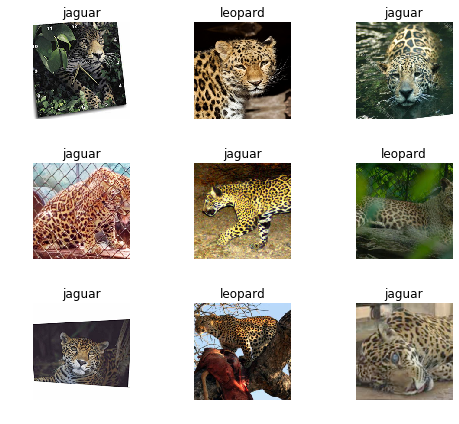

In [15]:
data.show_batch(rows = 3, figsize=(7,6))


## Train the Model

In [16]:
learn = cnn_learner(
    data, # Takes a databunch object
    models.resnet34, # Architechture - resnet works very well
                     # Smaller resnet trains faster
    metrics = error_rate # Please print the error rate
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 89864823.62it/s]


In [17]:
learn.fit_one_cycle(4) 

epoch,train_loss,valid_loss,error_rate,time
0,0.783758,0.388486,0.173077,00:10
1,0.567122,0.242768,0.105769,00:08
2,0.476094,0.242244,0.086538,00:09
3,0.417758,0.258199,0.086538,00:08


In [0]:
learn.save('stage-1') # Saves the first iteration of the model

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

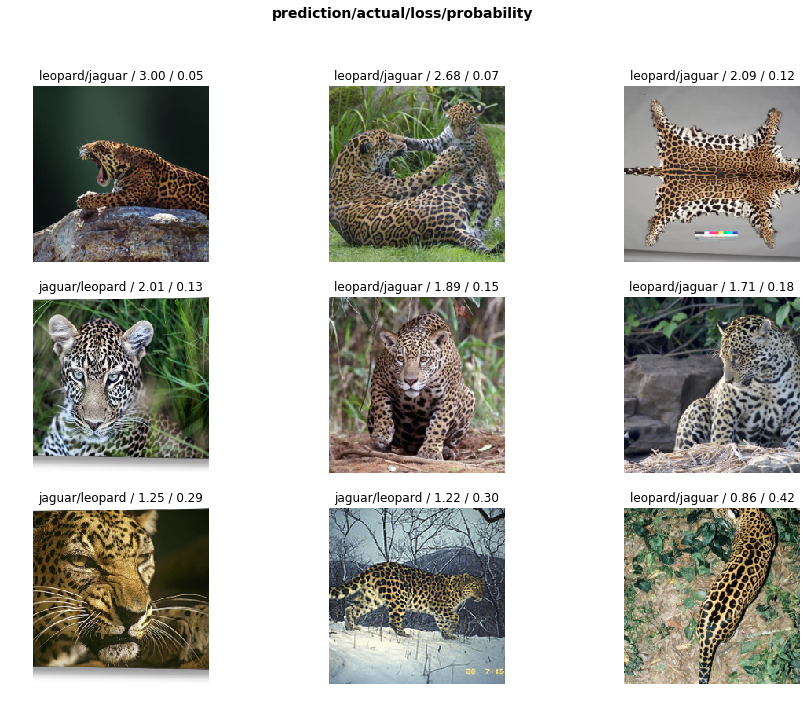

In [20]:
# Which images were we most confident about but got wrong?
interp.plot_top_losses(9, figsize=(15, 11), heatmap=False)

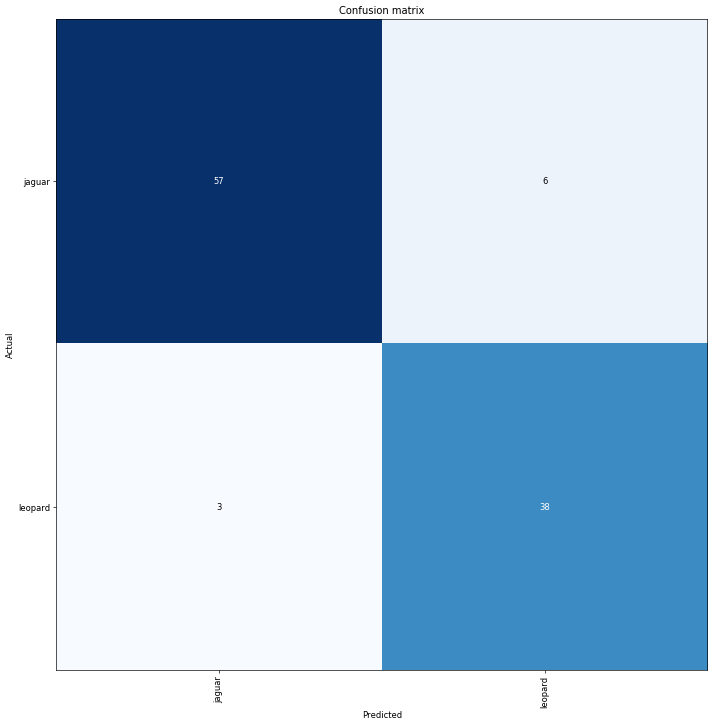

In [21]:
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

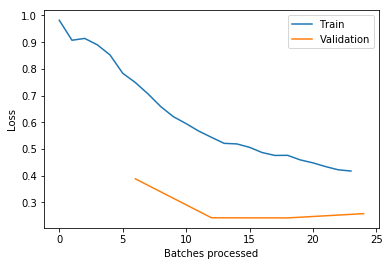

In [23]:
learn.recorder.plot_losses()

### Can we change the learning rate to improve the model?

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


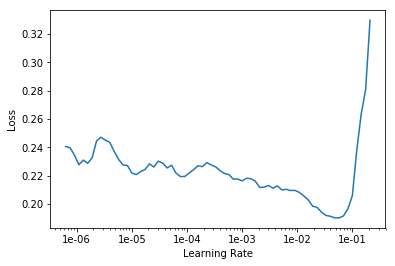

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze() # learn more specifics to the dataset I have
learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.390604,1.040107,0.230769,00:09
1,0.455009,0.536195,0.163462,00:09
2,0.372292,0.432773,0.096154,00:09
3,0.301952,0.340741,0.076923,00:09


### Productionalizing the Model

In [0]:
learn.export()


In [0]:
defaults.device = torch.device('cpu')

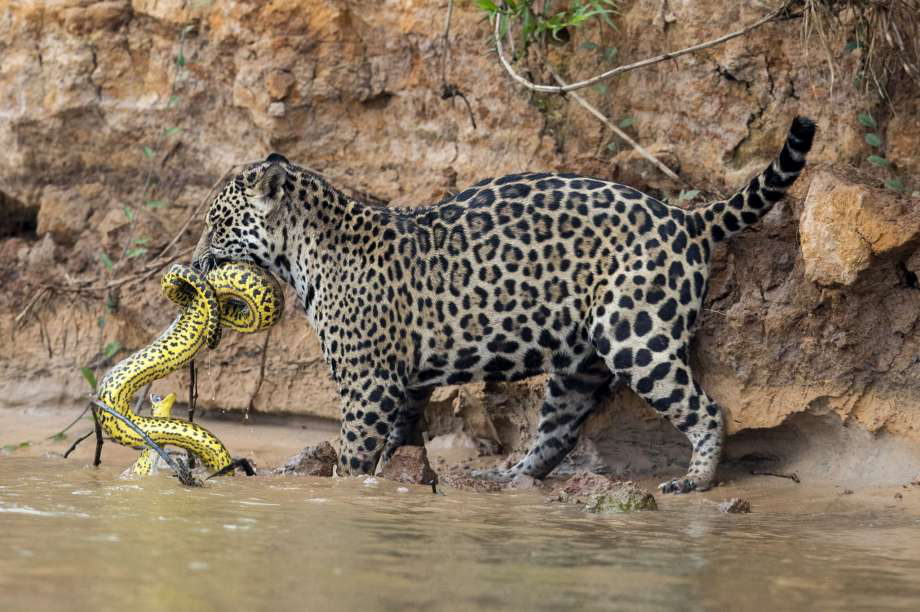

In [29]:
img = open_image(path/'test-jag.jpg')
img

In [0]:
learn = load_learner(path)

In [34]:
# Make a prediction - it was right!
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category jaguar

In [35]:
outputs

tensor([0.9981, 0.0019])

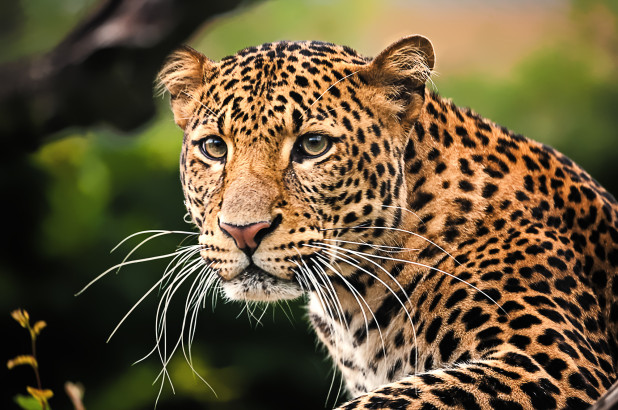

In [36]:
img = open_image(path/'test-leopard.jpg')
img

In [37]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category leopard

In [38]:
outputs

tensor([0.0082, 0.9918])